In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pandas_market_calendars as mcal
import datetime as dt
import scipy as sp

import pymc3 as pm
from theano import tensor as tt
from theano import shared
import arviz as az
az.style.use("arviz-darkgrid")

import os
import sys


from jupyterthemes import jtplot
jtplot.style(theme="monokai")

# data_processing.py

In the Markowitz case, the only two things we need from the data are the covariance matrix and a vector of expected returns for each asset.

In [2]:
os.listdir()

['.ipynb_checkpoints', 'Markowitz Notebook.ipynb', 'raw_data']

In [38]:
os.chdir(sys.path[0]+"/raw_data")
os.listdir()

['JNJ.csv', 'LNG.csv', 'MSFT.csv', 'TSLA.csv', 'V.csv']

In [39]:
# Read in files and grab daily close prices
df = pd.DataFrame(data={"returns"})
for n, fname in enumerate(os.listdir()):
    if n == 0:
        ticker = fname.split(".csv")[0]
        df = pd.read_csv(fname, index_col="Date", parse_dates=True)[["Adj Close"]].rename(columns={"Adj Close" : ticker})
    else:
        ticker = fname.split(".csv")[0]
        temp_df = pd.read_csv(fname, index_col="Date", parse_dates=True)[["Adj Close"]].rename(columns={"Adj Close" : ticker})
        df = pd.merge(df, temp_df, left_index=True, right_index=True)

In [40]:
# Convert to daily log returns
df = np.log(df) - np.log(df.shift(1))
df = df.dropna()

In [41]:
# Compute cov matrix
cov = df.cov()
cov.head()

,JNJ,LNG,MSFT,TSLA,V
JNJ,0.000158,0.000066,0.000110,0.000073,0.000105
LNG,0.000066,0.000566,0.000145,0.000212,0.000175
MSFT,0.000110,0.000145,0.000306,0.000266,0.000218
TSLA,0.000073,0.000212,0.000266,0.001322,0.000230
V,0.000105,0.000175,0.000218,0.000230,0.000271


In [42]:
# Compute mean log returns
means = df.mean()
means.head()

JNJ     0.000456
LNG     0.000339
MSFT    0.001166
TSLA    0.002220
V       0.000862
dtype: float64

In [47]:
# Save outputs
cov.to_csv("cov_matrix.csv")
means.to_csv("ex_returns.csv")

### Functions

In [2]:
def process_data():
    '''
    Computes and saves the covariance matrix + vector of expected returns.
    '''
    # Change directory
    os.chdir(sys.path[0]+"/raw_data")
    os.listdir()
    
    # Read in files and grab daily close prices
    df = pd.DataFrame(data={"returns"})
    for n, fname in enumerate(os.listdir()):
        if n == 0:
            ticker = fname.split(".csv")[0]
            df = pd.read_csv(fname, index_col="Date", parse_dates=True)[["Adj Close"]].rename(columns={"Adj Close" : ticker})
        else:
            ticker = fname.split(".csv")[0]
            temp_df = pd.read_csv(fname, index_col="Date", parse_dates=True)[["Adj Close"]].rename(columns={"Adj Close" : ticker})
            df = pd.merge(df, temp_df, left_index=True, right_index=True)
            
    # Convert to daily log returns
    df = np.log(df) - np.log(df.shift(1))
    df = df.dropna()
    
    # Compute cov matrix
    cov = df.cov()
    
    # Compute mean log returns
    means = df.mean()
    
    # Go back up a directory and save
    os.chdir(sys.path[0])
    cov.to_csv("cov_matrix.csv")
    means.to_csv("ex_returns.csv")

In [3]:
process_data()

In [4]:
os.listdir()

['.ipynb_checkpoints',
 'cov_matrix.csv',
 'ex_returns.csv',
 'Markowitz Notebook.ipynb',
 'raw_data']

# loss_function.py

Takes the covariance matrix and expected return vector to compute the loss function.

In [33]:
cov = pd.read_csv("cov_matrix.csv", index_col=0).values
means = pd.read_csv("ex_returns.csv", index_col=0).values

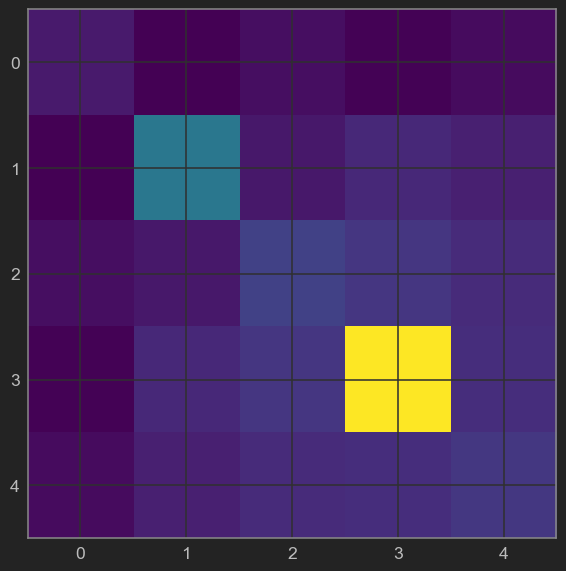

In [18]:
plt.imshow(cov)
plt.show()

In [25]:
# Dummy vector of weights
w = np.array([0.1, 0.1, 0.0, 0.4, 0.4])
print(w.shape)

(5,)


In [26]:
cov.shape

(5, 5)

In [29]:
np.matmul( w.T , np.matmul(cov, w) )

0.0003823178455655033

In [34]:
np.matmul( means.T, w )

array([0.00131257])

### Functions

In [60]:
def loss(weights, cov, means, q):
    '''
    Loss function for markowitz mean-variance optimization. q \in [0, \infty), represents risk tolerance.
    '''
    term1 = np.matmul( w.T , np.matmul(cov, w) )
    term2 = - q*np.matmul( means.T, w )
    return term1 + term2

# optimize.py
This function finds the optimal weights.

In [49]:
from scipy.optimize import minimize

In [47]:
rand_nums = np.random.randint(100, size=5)
rand_weight = rand_nums/rand_nums.sum()
print(rand_weight)

[0.24761905 0.17142857 0.06190476 0.09047619 0.42857143]


In [159]:
q = 0.0
result = minimize(loss, rand_weight, args=(cov, means, q))
optimal_weight = result.x
print(optimal_weight)

[0.24761905 0.17142857 0.06190476 0.09047619 0.42857143]


### Functions

In [259]:
# This one doesn't use convex optimization, and keeps falling into local optimums.
# def find_optimal_weights(loss, cov, means, q, niter=1000):
#     '''
#     Given the loss function, finds and returns the minizing weight vector.
#     '''
#     from scipy.optimize import minimize, basinhopping
    
#     rand_nums = np.random.randint(100, size=5)
#     rand_weight = rand_nums/rand_nums.sum()
#     #result = minimize(loss, rand_weight, args=(cov, means, q), tol=tol)
#     result = basinhopping(loss, rand_weight, niter=niter, minimizer_kwargs={"args":(cov, means, q)})
#     optimal_weight = result.x    
    
#     return optimal_weight

def find_optimal_weights(loss, cov, means, q):
    '''
    Given the loss function, finds and returns the minizing weight vector.
    '''
    import cvxpy as cp
    
    w = cp.Variable(5)
    risk_tol = cp.Parameter(nonneg=True)
    ret = means.T*w 
    risk = cp.quad_form(w, cov)
    prob = cp.Problem(cp.Minimize(risk - risk_tol*ret), 
                   [cp.sum(w) == 1, 
                    w >= 0])
    risk_tol.value = q
    prob.solve()
    risk_data = cp.sqrt(risk).value
    ret_data = ret.value
    
    return w.value

In [260]:
q = 10.0
res = find_optimal_weights(loss, cov, means, q)

C:\Users\Jonathan\anaconda3\lib\site-packages\cvxpy\expressions\expression.py:550: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.

  warnings.warn(__STAR_MATMUL_WARNING__, UserWarning)


In [70]:
tickers = pd.read_csv("cov_matrix.csv", index_col=0).index.to_list()

In [79]:
import csv

In [80]:
weight_dict = dict(zip(tickers, res))

In [82]:
with open('optimal_weights.csv', 'w') as f:
    f.truncate()
    for key in weight_dict.keys():
        f.write("%s,%s\n"%(key,weight_dict[key]))

In [83]:
print()
print("Optimal Portfolio Weights:")
print()
for key, value in weight_dict.items():
    print("{}: {}".format(key, value))
print()


Optimal Portfolio Weights:

JNJ: 0.21839080459770116
LNG: 0.05747126436781609
MSFT: 0.22413793103448276
TSLA: 0.10919540229885058
V: 0.39080459770114945



# analysis.py
Tools for analyzing results and seeing if things make sense.

In [85]:
def compute_port_stdev(weights, cov):
    '''
    Given weights and covariance matrix, computes portfolio annualized volatility.
    '''
    port_var = np.matmul(weights.T, np.matmul(cov, weights))
    return np.sqrt(port_var)

In [86]:
def compute_port_ret(weights, means):
    '''
    Given weights and means, computes portfolio expected return vector.
    '''
    return np.matmul(means.T, weights)

In [ ]:
rand_nums = np.random.randint(100, size=5)
    rand_weight = rand_nums/rand_nums.sum()

In [87]:
np.random.randint(100, size=(1000, 5))

array([[17, 85, 67, 31, 54],
       [68, 43, 62, 50, 14],
       [76, 41, 26, 16, 15],
       ...,
       [64, 37, 44, 81, 15],
       [73, 65,  5, 47, 45],
       [23, 36, 80, 38, 62]])

In [288]:
def plot_frontier(cov, means, opt_w, num=100):
    '''
    Given cov matrix and expected returns, plots the portfolio space. 
    '''
    # Compute returns and stdevs for random portfolios
    rand_nums = np.random.randint(100, size=(num, 5))
    rand_nums = rand_nums.astype(float)
    rand_weights = rand_nums.copy()
    for j in range(rand_nums.shape[1]):
        rand_weights[:,j] = np.true_divide(rand_nums[:,j], rand_nums.sum(axis=1))
        
    returns = []
    stdevs = []
    for j in range(num):
        returns.append(compute_port_ret(rand_weights[j,:], means))
        stdevs.append(compute_port_stdev(rand_weights[j,:], cov))
    
    ret_opt = compute_port_ret(opt_w, means)
    stdev_opt = compute_port_stdev(opt_w, cov)
    
    plt.scatter(stdevs, returns, color="blue", label="Random Portfolios")
    plt.scatter(stdev_opt, ret_opt, color="red", s=40, label="Optimal Portfolio")
    plt.xlabel("Portfolio Volatility")
    plt.ylabel("Portfolio Expected Return")
    plt.title("Risk-Return Tradeoff")
    plt.show()

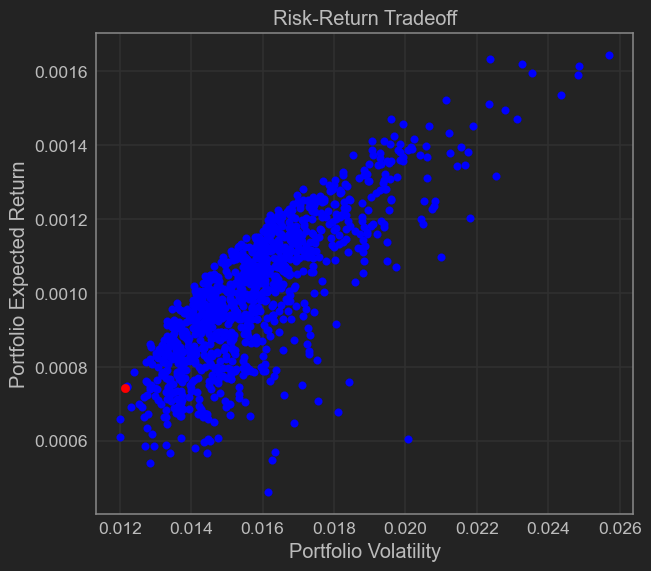

In [290]:
plot_frontier(cov, means, opt_w, num=1000)

In [165]:
# Compute returns and stdevs for random portfolios
num = 20000
rand_nums = np.random.randint(100, size=(num, 5))
rand_nums = rand_nums.astype(float)
rand_weights = rand_nums.copy()
for j in range(rand_nums.shape[1]):
    rand_weights[:,j] = np.true_divide(rand_nums[:,j], rand_nums.sum(axis=1))
    
returns = []
stdevs = []
for j in range(num):
    returns.append(compute_port_ret(rand_weights[j,:], means))
    stdevs.append(compute_port_stdev(rand_weights[j,:], cov))

In [148]:
# Compute mean and stdev of optimal portfolio

In [270]:
q = 0.5
res = find_optimal_weights(loss, cov, means, q)

ret_opt = compute_port_ret(res, means)
stdev_opt = compute_port_stdev(res, cov)

C:\Users\Jonathan\anaconda3\lib\site-packages\cvxpy\expressions\expression.py:550: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.

  warnings.warn(__STAR_MATMUL_WARNING__, UserWarning)


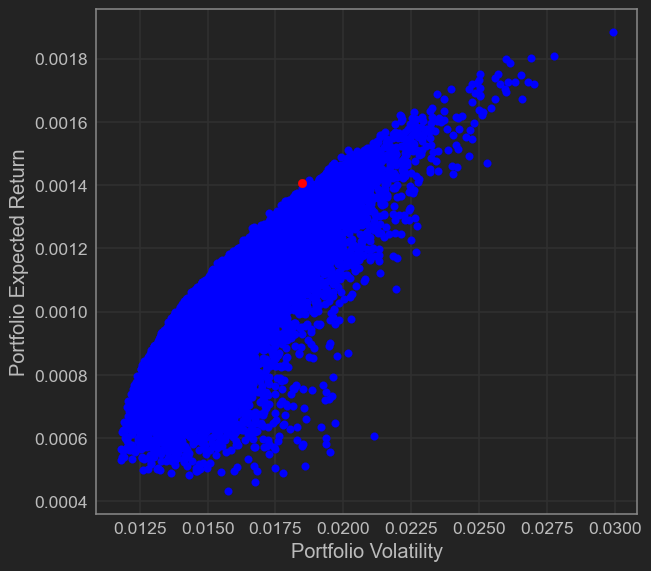

In [271]:
plt.scatter(stdevs, returns, color="blue", label="Random Portfolios")
plt.scatter(stdev_opt, ret_opt, color="red", s=40, label="Optimal Portfolio")
plt.xlabel("Portfolio Volatility")
plt.ylabel("Portfolio Expected Return")
plt.title("Risk-Return Tradeoff")
plt.show()

In [287]:
import csv
with open('optimal_weights.csv', mode='r') as infile:
    reader = csv.reader(infile)
    opt_w = {rows[0]:float(rows[1]) for rows in reader}
    opt_w = np.array(list(opt_w.values()))

# Experimenting

In [230]:
import cvxpy as cp

In [240]:
w = cp.Variable(5)
gamma = cp.Parameter(nonneg=True)
ret = means.T*w 
risk = cp.quad_form(w, cov)
prob = cp.Problem(cp.Maximize(ret - gamma*risk), 
               [cp.sum(w) == 1, 
                w >= 0])
gamma.value = 0.0
prob.solve()
risk_data = cp.sqrt(risk).value
ret_data = ret.value

C:\Users\Jonathan\anaconda3\lib\site-packages\cvxpy\expressions\expression.py:550: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.

  warnings.warn(__STAR_MATMUL_WARNING__, UserWarning)


In [253]:
w = cp.Variable(5)
q = cp.Parameter(nonneg=True)
ret = means.T*w 
risk = cp.quad_form(w, cov)
prob = cp.Problem(cp.Minimize(risk - q*ret), 
               [cp.sum(w) == 1, 
                w >= 0])
q.value = 0.3
prob.solve()
risk_data = cp.sqrt(risk).value
ret_data = ret.value

C:\Users\Jonathan\anaconda3\lib\site-packages\cvxpy\expressions\expression.py:550: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.

  warnings.warn(__STAR_MATMUL_WARNING__, UserWarning)


In [256]:
w.value

array([3.56199175e-01, 2.09205133e-23, 4.36085002e-01, 1.78664192e-01,
       2.90516314e-02])

In [ ]:
def find_optimal_weights(loss, cov, means, q, niter=1000):
    '''
    Given the loss function, finds and returns the minizing weight vector.
    '''
    from scipy.optimize import minimize, basinhopping
    
    rand_nums = np.random.randint(100, size=5)
    rand_weight = rand_nums/rand_nums.sum()
    #result = minimize(loss, rand_weight, args=(cov, means, q), tol=tol)
    result = basinhopping(loss, rand_weight, niter=niter, minimizer_kwargs={"args":(cov, means, q)})
    optimal_weight = result.x    
    
    return optimal_weight